In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json
import numpy as np

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zixuanwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Introduction to Networkx

The simple methods '.nodes()' and '.edges()' print the key components of the network.

In [2]:
HG = nx.house_graph()
HG.nodes()
HG.edges()

NodeView((0, 1, 2, 3, 4))

EdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

## Drawing the network

To draw the network, we need to give it a dictionary that maps each node to an X-Y coordinate. I give one below.

{0: Text(0, 0, '0'),
 1: Text(1, 0, '1'),
 2: Text(0, 1, '2'),
 3: Text(1, 1, '3'),
 4: Text(0.5, 2.0, '4')}

(-0.10500000000000001, 1.105, -0.21000000000000002, 2.21)

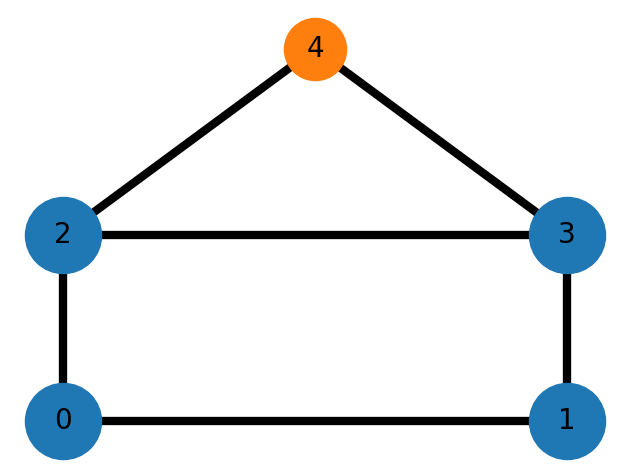

In [3]:
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

nx.draw_networkx_nodes(
    HG, pos, node_size=3000, nodelist=[0, 1, 2, 3], 
    node_color="tab:blue"
)

nx.draw_networkx_nodes(HG, pos, node_size=2000, 
                       nodelist=[4], node_color="tab:orange")

nx.draw_networkx_edges(HG, pos, alpha=1, width=6)
nx.draw_networkx_labels(HG, pos, font_size=20)
plt.tight_layout()
plt.axis("off")

In [4]:
ADJ = nx.to_pandas_adjacency(HG)
ADJ = ADJ.astype(bool)

In [5]:
deg_0 = nx.degree(HG, 0) 
deg_0

2

# Activity
We will learn how to process a dataframe into a useable edgelist to feed into a graph.

In [6]:
df = pd.read_pickle("../public_data/Raw_Tweets.pkl") # Load your tweets
df.head()
df.shape

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


(59887, 15)

### 1.1 Subset the dataframe to network data

- First, using .value_counts(), identify how many types of tweets there are, using the tweet_type column. 
- Then, filter out all tweets that are not "retweeted_tweet_without_comment" and "quoted_tweet."

In [7]:
# your code here
df.tweet_type.value_counts()

tweet_type
original                           26275
retweeted_tweet_without_comment    19923
reply                               7292
quoted_tweet                        6397
Name: count, dtype: int64

In [8]:
## Run this. Why is it empty?
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


In [9]:
df_filtered = df[df.tweet_type.isin(["retweeted_tweet_without_comment", "quoted_tweet"])]
df_filtered.tweet_type.value_counts()

tweet_type
retweeted_tweet_without_comment    19923
quoted_tweet                        6397
Name: count, dtype: int64

### 1.2 Create an edgelist

The "userid" column shows the person that did the retweeting. Create a new column called "userid2" that denotes the user retweeted. You will need to use the columns "rt_userid" and "qtd_userid."

In [10]:
df_filtered["userid2"] = np.where(df_filtered.qtd_userid.isnull(), df_filtered.rt_userid, df_filtered.qtd_userid)
df_filtered.head()

/var/folders/w7/k4k3jfz96q7_tpr10dw1cs580000gn/T/ipykernel_60744/4292307092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["userid2"] = np.where(df_filtered.qtd_userid.isnull(), df_filtered.rt_userid, df_filtered.qtd_userid)


,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid,userid2
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN,9.200360e+17
25575,1222280171501256706,20467163,Tue Jan 28 22:07:56 +0000 2020,en,RT @RCCallihan: The declaration of a public he...,retweeted_tweet_without_comment,10261,30106,2762,"[1697808410, 146569971]",1.697808e+09,1.222247e+18,NaN,NaN,NaN,1.697808e+09
28489,1222283902724820995,426033838,Tue Jan 28 22:22:46 +0000 2020,en,RT @DepSecHargan: Start the #NewYear off right...,retweeted_tweet_without_comment,625,1823,22314,"[920035992073064450, 146569971]",9.200360e+17,1.222239e+18,NaN,NaN,NaN,9.200360e+17
28496,1222283757119590405,426033838,Tue Jan 28 22:22:11 +0000 2020,en,RT @CDCFlu: Elevated #flu activity is expected...,retweeted_tweet_without_comment,625,1823,22314,[16616061],1.661606e+07,1.222194e+18,NaN,NaN,NaN,1.661606e+07
12992,1220696703667326976,426033838,Fri Jan 24 13:15:48 +0000 2020,en,RT @CDCemergency: Is it a cold or flu? What’s ...,retweeted_tweet_without_comment,625,1822,22325,[19658936],1.965894e+07,1.220488e+18,NaN,NaN,NaN,1.965894e+07


### 1.3 Sentiment scoring. 
- Now, use SentimentIntensityAnalyzer to label the sentiment of the text, in a new column called "weight." 
- The subset the dataframe to only have "userid", "user2", and "weight". 
- Rename "userid" to "user1", then group by "user1" and "user2", to find the mean sentiment (mean weight).

You now have your first edgelist!

In [11]:
sent_obj = SentimentIntensityAnalyzer()

In [12]:
df_filtered = df_filtered[~df_filtered.text.isna()]

In [13]:
df_filtered.userid2 = df_filtered.userid2.astype(np.int64)
df_filtered["weight"] = df_filtered["text"].apply(lambda x: sent_obj.polarity_scores(x)["compound"])

In [14]:
df_subset = df_filtered[["userid", "userid2", "weight"]]
df_subset = df_subset.rename(columns = {"userid":"user1"})
df_subset = df_subset.rename(columns = {"userid2":"user2"})

In [15]:
df_subset.groupby(["user1", "user2"])["weight"].mean()

user1                user2              
5558312              5558312                0.7263
                     20093858               0.6705
                     20562924               0.5106
                     28743031               0.5106
                     50907797               0.8831
                                             ...  
815952318487298048   1008376462506971136    0.4404
                     1080865917377097728   -0.4019
1075205691621720064  3382591954             0.0000
                     1075205691621720064    0.7717
                     1083125649609506816    0.0000
Name: weight, Length: 9370, dtype: float64

# Netwulf Visualization
#### If you don't have the module, pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [16]:
EL =  pd.read_pickle("../public_data/edge_list_final2.pkl")
EL

,user1,user2,text,vaderSent
26,426033838,146569971,RT @CDCgov: The first human infection with new...,0.0000
150,418859255,146569971,"RT @CDCgov: After being diagnosed at age 41, C...",0.4939
146,418859255,146569971,RT @CDCgov: New CDC study: transgender women d...,0.0000
140,418859255,146569971,RT @CDCgov: While limited person-to-person spr...,-0.2263
134,418859255,146569971,RT @CDCgov: CDC has been proactively preparing...,0.0000
...,...,...,...,...
434,78445977,78445977,"Virginians, you have one hour left to vote in ...",0.0000
14339,35239459,14499829,"RT @WHO: This #Halloween, let's spook #COVID19...",0.4574
51918,2953974395,5558312,"During #COVID19, I have been in continuous com...",0.6369
51918,2953974395,1209417007,"During #COVID19, I have been in continuous com...",0.6369


In [17]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]])

In [18]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

# Creates the biggest subgraph
CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [19]:
from netwulf import visualize
import netwulf as nw

In [20]:
stylized_network, config = visualize(GG,)

/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [21]:
U = pd.read_pickle("../public_data/UserInfo.pkl")
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

In [22]:
stylized_network, config = visualize(GG,port=2000)

/opt/anaconda3/envs/qss20/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


### Activity Two
- Create a new column in U called "Degree," which denotes the degree of the node (userid). You will want to use G.degree()[n] where n is the userid.
- Group by User Type. Which group was the most popular during the pandemic?

In [23]:
G.degree()

DegreeView({426033838: 13, 146569971: 225, 418859255: 26, 14499829: 68, 247334603: 34, 1080509366: 18, 44783853: 136, 15751083: 17, 16952753: 15, 123926499: 9, 2363238127: 20, 15134240: 41, 407228333: 13, 36790269: 3, 131546062: 22, 2910903323: 56, 44034613: 25, 24959108: 21, 323311059: 11, 455024343: 74, 23711785: 10, 44957814: 19, 33934492: 18, 90422822: 9, 24195214: 39, 31801993: 18, 35789875: 9, 18695134: 25, 946549322: 21, 109287731: 23, 1071900114: 10, 20545793: 5, 232268199: 20, 57338289: 7, 1058520120: 21, 2964174789: 19, 236511574: 11, 235217558: 20, 293131808: 26, 224285242: 16, 252114970: 13, 460473395: 12, 68412042: 17, 240760644: 12, 3218464527: 16, 414860556: 13, 50452197: 9, 1249982359: 80, 476256944: 14, 18915145: 14, 815379032: 2, 19291441: 14, 25149628: 12, 21157904: 6, 1074101017: 8, 2916915026: 14, 78450167: 8, 970207298: 35, 44961877: 12, 76761964: 10, 2535616304: 9, 431100994: 17, 3177403355: 9, 70837868: 26, 2978837542: 10, 1074518754: 19, 35239459: 15, 20217019:

In [24]:
deg = pd.DataFrame(G.degree(), columns = ["userid", "degree"])
U = U.merge(deg)

In [25]:
# your code here.
U["Degree"] = U["userid"].map(dict(G.degree()))
# U["Degree"] = U["userid"].apply(lambda x:nx.degree(G,x))

<BarContainer object of 4 artists>

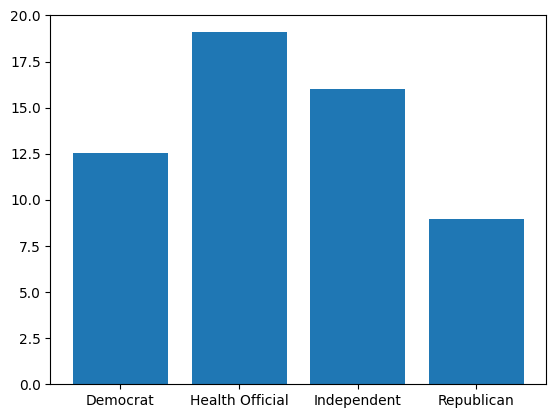

In [26]:
# bar = U.groupby("User_type")["degree"].sum()
bar = U.groupby("User_type")["degree"].mean()
plt.bar(bar.index, bar.values)